In [1]:
################################################################################                                                                                                                                                              
################################################################################
#
# FILE: basketball-panel.ipynb
#
# BY: Dmitry Sedov 
#
# CREATED: Mon Jul 27 2020
#
# DESC: This code constructs a panel dataset for visits to basketball stadiums.
#
# EXEC:
#      
################################################################################
################################################################################

In [2]:
################################## INPUT #######################################

industries_unique = [22, 23, 31, 42, 44, 48, 51, 52,
                     53, 54, 55, 61, 62, 71, 72]

industries = {11: [11], 
              21: [21], 
              22: [22], 
              23: [23], 
              31: [31, 32, 33], 
              32: [31, 32, 33], 
              33: [31, 32, 33], 
              42: [42], 
              44: [44, 45], 
              45: [44, 45], 
              48: [48, 49],
              49: [48, 49], 
              51: [51], 
              52: [52], 
              53: [53], 
              54: [54], 
              55: [55], 
              56: [56], 
              61: [61], 
              62: [62], 
              71: [71], 
              72: [72],
              81: [81], 
              92: [92]}

naics_2dig = {11: 'Agriculture', 
              21: 'Mining', 
              22: 'Utilities', 
              23: 'Construction', 
              31: 'Manufacturing', 
              32: 'Manufacturing', 
              33: 'Manufacturing', 
              42: 'Wholesale', 
              44: 'Retail', 
              45: 'Retail', 
              48: 'Transportation',
              49: 'Transportation', 
              51: 'Information', 
              52: 'Finance', 
              53: 'RealEstate', 
              54: 'Professional', 
              55: 'Management', 
              56: 'Administrative', 
              61: 'Education', 
              62: 'Health', 
              71: 'Recreation', 
              72: 'FoodAccommodation',
              81: 'Other', 
              92: 'PublicAdministration'}

################################################################################

In [3]:
################################ Libraries #####################################

import sqlalchemy as db
import pandas as pd

import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

################################################################################

/home/user/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
################################# Options ######################################

pd.options.display.max_rows = 500

################################################################################

In [5]:
################################ Constants #####################################

project_folder = '/home/user/projects/stadiums'
teams_output_folder = os.path.join(project_folder, 'data/basketball/teams/')
games_output_folder = os.path.join(project_folder, 'data/basketball/games/')

################################################################################

In [6]:
###################### Import stadiums and game dates ##########################

stadiums = pd.read_csv(os.path.join(teams_output_folder,
                                    'basketball_teams.csv'),
                       usecols = ['name', 'code']
                      )

matching = pd.read_csv(os.path.join(teams_output_folder,
                                    'basketball_matching.csv')
                      )

stadiums = pd.merge(stadiums, 
                    matching,
                    on = 'name',
                    how = 'inner',
                    validate = 'one_to_one')

stadiums.set_index('code', inplace = True)

################################################################################

In [7]:
############################ PostgreSQL connection #############################

engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname2}')

################################################################################

In [8]:
################ Import stadiums, visits and game dates ########################

def import_games(year, code):
    """Read in and clean data for year-team."""
    # Set paths
    games_year_folder = os.path.join(games_output_folder, str(year))
    code_file_name_1 = code + '_season_games.csv'
    code_file_name_2 = code + '_playoff_games.csv'
    year_code_file_path_1 = os.path.join(games_year_folder, code_file_name_1)
    year_code_file_path_2 = os.path.join(games_year_folder, code_file_name_2)
    # Import
    data = pd.read_csv(year_code_file_path_1)
    if os.path.exists(year_code_file_path_2):
        data = data.append(pd.read_csv(year_code_file_path_2), ignore_index = True)
    # Filter for home games only
    mask = data['Unnamed: 5'].isnull()
    data = data[mask]
    # Get rid of double-dates
    # data['Date'] = data['Date'].apply(lambda x: x.split('(')[0].strip())
    data.drop_duplicates(subset = ['Date'], inplace = True)
    # Format dates
    #data['Date'] = (data['Date'].apply(lambda x: x.split(',')[1].strip()) + 
    #                ' ' + data['year'].astype('str')
    #               )
    data['Date'] = pd.to_datetime(data['Date'], format = '%a, %b %d, %Y')
    return data[['Date', 'team_code']]

def import_visits(year, sg_id):
    """Read in the SG visits data."""
    
    search_query = f"""
    SELECT 
        sname_place_id,
        year,
        month,
        raw_visit_counts,
        visits_by_day
    FROM 
        visits
    WHERE
        sname_place_id = '{sg_id}'
    AND
        year = {year}
    ;
    """
    results = pd.read_sql(search_query, con = engine)
    rows = []
    _ = results.apply(lambda row: [rows.append([row['sname_place_id'],
                                                row['year'],
                                                row['month'],
                                                day + 1,
                                                v]) 
                                   for day, v in enumerate(row.visits_by_day)],
                      axis = 1)
    results = pd.DataFrame(rows,
                           columns = ['sname_place_id', 
                                      'year', 
                                      'month', 
                                      'day', 
                                      'stadium_visits'])
    results.sort_values(['year', 'month', 'day'], inplace = True)
    results['Date'] = results[['day', 
                               'month', 
                               'year']
                             ].apply(lambda x: ' '.join(x.map(str)), 
                                     axis = 1)
    results['Date'] = pd.to_datetime(results['Date'], 
                                     format = '%d %m %Y')
    results = results[['sname_place_id', 'Date', 'year', 'month', 'day', 'stadium_visits']]
    return results

def import_games_visits(year, code):
    
    games = import_games(year, code)
    if year == 2017:
        sg_id = stadiums.at[code, 'sg_id_2017']
    elif year == 2018:
        sg_id = stadiums.at[code, 'sg_id_2018']
    elif year == 2019:
        sg_id = stadiums.at[code, 'sg_id_2019']
    visits = import_visits(year, sg_id)
    
    data = pd.merge(visits, 
                    games,
                    on = 'Date',
                    how = 'left',
                    validate = 'one_to_one')
    
    data['game'] = 1 - data['team_code'].isnull().astype('int')
    data['team'] = code
    
    # Visits to integer
    data['stadium_visits'] = data['stadium_visits'].astype('int')
    
    return data

def import_code_data(code):
    """Get data for all three years for a team code."""
    
    data = [import_games_visits(y, code) for y in range(2017, 2020)]
    
    return pd.concat(data).reset_index(drop = True)

################################################################################

In [9]:
test2 = import_code_data('ATL')

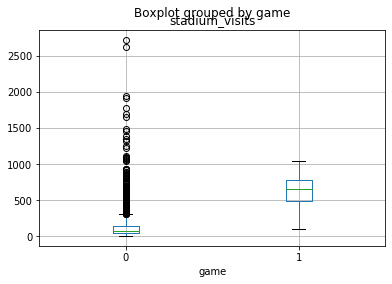

In [10]:
test2.boxplot(column = ['stadium_visits'], by = 'game')

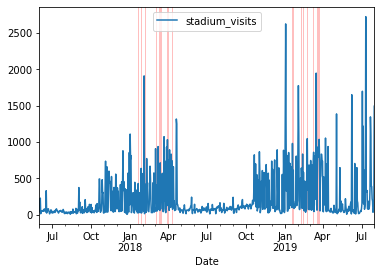

In [11]:
ax = test2.plot(x = 'Date', y = 'stadium_visits')

def highlight(indices, ax):
    i = 0
    while i < len(indices) - 1:
        ax.axvspan(test2.Date[indices[i]], 
                   test2.Date[indices[i] + 1],
                   facecolor = 'red', 
                   edgecolor = 'none',
                   alpha = 0.25)
        i += 1
        
highlight(test2[test2['game'] == 1].index, ax)

In [12]:
data = [import_code_data(x) for x in stadiums.index]

In [13]:
data = pd.concat(data).reset_index(drop = True)

In [14]:
# Stadiums with two associated teams: get one stadium only
data.rename(columns = {'sname_place_id': 'stadium_id'}, inplace = True)
data = data.sort_values('game', 
                        ascending = False
                       ).groupby(['stadium_id', 'Date']
                                ).first().reset_index()

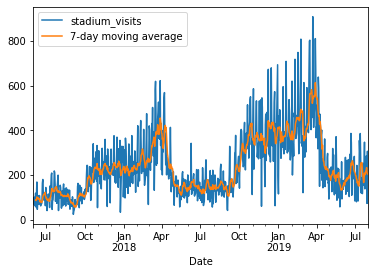

In [15]:
# Plot the visits time series
by_date = data[['Date', 'stadium_visits']].groupby('Date').mean()
by_date['7-day moving average'] = by_date.rolling(window = 7).mean()
by_date.plot()

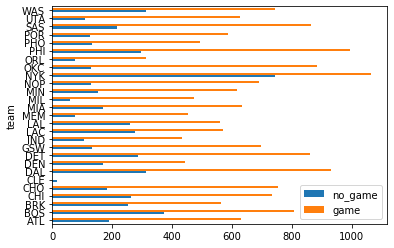

In [16]:
# Plot the visits by game status by team
by_game_status = data[['team', 'game', 'stadium_visits']
                     ].groupby(['team', 'game']
                              ).mean()
by_game_status.reset_index(inplace = True)
by_game_status = pd.pivot_table(by_game_status, values = 'stadium_visits', index = 'team', columns = 'game')
by_game_status.columns = ['no_game', 'game']
by_game_status.plot.barh()

In [17]:
############### Insert new stadiums from the establishments table ##############

engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname2}')

# Create a list of sname_place_ids of stadiums
stadiums_sg_ids = stadiums[['sg_id_2017', 
                            'sg_id_2018', 
                            'sg_id_2019']].stack().reset_index()[0]

stadiums_sg_ids = "('" + "','".join(list(set(stadiums_sg_ids.to_list()))) + "')"

create_stadiums_table_statement = f"""
DELETE FROM stadiums
WHERE sport = 'basketball';

INSERT INTO stadiums 
SELECT 
    *,
    'basketball' as sport
FROM
    establishments 
WHERE
    sname_place_id IN {stadiums_sg_ids}
"""

with engine.connect() as connection:
    result = connection.execute(create_stadiums_table_statement)

engine.dispose()

################################################################################

In [18]:
for industry in industries_unique:
    
    print(naics_2dig[industry])

    engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname2}')

############ Create versions of the tables with geography ######################

    create_temp_stadiums_table_with_geo = """
    CREATE TEMPORARY TABLE IF NOT EXISTS stadiums_with_geo AS
    SELECT
        sname_place_id,
        ST_SetSRID(ST_POINT(longitude, latitude), 4326)::geography AS s_location
    FROM
        stadiums
    WHERE 
        sport = 'basketball'
        ;

    CREATE INDEX IF NOT EXISTS stadiums_with_geo_sg_idx
    ON stadiums_with_geo (sname_place_id);

    CREATE INDEX IF NOT EXISTS stadiums_with_geo_location_idx
    ON stadiums_with_geo
    USING GIST(s_location);
    """

    industry_codes = f"{industries[industry]}".replace('[', '(').replace(']', ')')

    if industry == 72:
        create_temp_places_table_with_geo = f"""
        CREATE TEMPORARY TABLE IF NOT EXISTS places_with_geo AS
        SELECT
            sname_place_id,
            ST_SetSRID(ST_POINT(longitude, latitude), 4326)::geography AS p_location
        FROM
            establishments
        WHERE
            naics_code / 10000 IN {industry_codes}
        UNION
        SELECT
            sname_place_id,
            ST_SetSRID(ST_POINT(longitude, latitude), 4326)::geography AS p_location
        FROM
            restaurants
        ;
        """
    else:
        create_temp_places_table_with_geo = f"""
        CREATE TEMPORARY TABLE IF NOT EXISTS places_with_geo AS
        SELECT
            sname_place_id,
            ST_SetSRID(ST_POINT(longitude, latitude), 4326)::geography AS p_location
        FROM
            establishments
        WHERE
            naics_code / 10000 IN {industry_codes}
        ;
        """



    create_temp_places_table_with_geo += """
        CREATE INDEX IF NOT EXISTS places_with_geo_sg_idx
        ON places_with_geo (sname_place_id);

        CREATE INDEX IF NOT EXISTS places_with_geo_location_idx
        ON places_with_geo
        USING GIST(p_location);
        """



    with engine.connect() as connection:
        result = connection.execute(create_temp_stadiums_table_with_geo)

    with engine.connect() as connection:
        result = connection.execute(create_temp_places_table_with_geo)

################################################################################

################## Perform a left join stadiums - places #######################

    select_places_close_to_stadiums = """
    WITH joined_by_distance AS (
    SELECT
        p.sname_place_id AS place_id,
        s.sname_place_id AS stadium_id,
        ST_Distance(s.s_location, p.p_location) AS distance
    FROM
        stadiums_with_geo AS s
    LEFT JOIN
        places_with_geo AS p
    ON
        ST_DWithin(s.s_location, p.p_location, 5000)
    AND
        s.sname_place_id != p.sname_place_id)
    SELECT 
        j.*,
        v.year,
        v.month,
        v.visits_by_day
    FROM 
        joined_by_distance AS j
    INNER JOIN
        visits AS v
    ON
        j.place_id = v.sname_place_id
    WHERE 
        year = 2018;
    """

    places_close_to_stadiums = pd.read_sql(select_places_close_to_stadiums, 
                                           con = engine)

################################################################################
    rows = []
    _ = places_close_to_stadiums.apply(lambda row: [rows.append([row['place_id'],
                                                                 row['stadium_id'],
                                                                 row['distance'],
                                                                 row['year'],
                                                                 row['month'],
                                                                 day + 1,
                                                                 v])
                                                    for day, v in enumerate(row.visits_by_day)],
                                       axis = 1)
    places_close_to_stadiums = pd.DataFrame(rows,
                                            columns = ['place_id',
                                                       'stadium_id',
                                                       'distance',
                                                       'year', 
                                                       'month', 
                                                       'day', 
                                                       'visits'])

    engine.dispose()

    places_close_to_stadiums = pd.merge(places_close_to_stadiums,
                                        data, 
                                        how = 'left', 
                                        on = ['stadium_id', 
                                              'year', 
                                              'month', 
                                              'day'], 
                                        validate = 'many_to_one')

    places_close_to_stadiums['dow'] = places_close_to_stadiums['Date'].apply(lambda x: x.weekday())

    places_close_to_stadiums.drop(columns = ['year', 'day', 'team', 'team_code'], inplace = True)

    # Drop stadiums which were built later than the sample, or for which 
    # not enough data is available
    mask = places_close_to_stadiums['dow'].isnull()
    places_close_to_stadiums[mask].stadium_id.unique()
    places_close_to_stadiums.dropna(subset = [x for x in places_close_to_stadiums.columns], 
                                    inplace = True)
    places_close_to_stadiums['dow'] = places_close_to_stadiums['dow'].astype('int')
    places_close_to_stadiums['month'] = places_close_to_stadiums['month'].astype('int')
    places_close_to_stadiums['stadium_visits'] = places_close_to_stadiums['stadium_visits'].astype('int')
    places_close_to_stadiums['game'] = places_close_to_stadiums['game'].astype('int')

    file_name = f'stadiums_{naics_2dig[industry]}.dta'
    outfile_path = os.path.join(project_folder, 
                                'data/processed',
                                'basketball',
                                file_name)
    places_close_to_stadiums.to_stata(path = outfile_path,
                                      convert_dates = {'Date': 'td'}, 
                                      write_index = False)

FoodAccommodation
Here
